# Selecting, Training, and Storing Prediction Models

In [25]:
%matplotlib inline
import os
import pickle
import numpy as np
import random as python_random
import sklearn
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, loguniform, randint
import pandas as pd
import xgboost
import matplotlib.pyplot as plt

In [11]:
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

In [12]:
# if os.getcwd().split("/")[-1] != 'intern-take-home-assessment':
#     os.chdir("./code/3m-internship/intern-take-home-assessment")

Load the modeling dataset

In [13]:
model_data = pd.read_csv('./preppared-data/model-data.csv')

## Making Train, Test Data

### Randomizing Train, and Test Data

In [14]:
train, test = train_test_split(model_data, test_size=0.2, random_state=1234)
print(f"train, test: {train.shape}, {test.shape}")
# First column of the test and train are profit which is the label (y)
X_train, X_test = train.iloc[:, 1:].to_numpy(), test.iloc[:, 1:].to_numpy()
y_train, y_test = train.iloc[:, 0].values.reshape(-1, 1), test.iloc[:, 0].values.reshape(-1, 1)

train, test: (5780, 21), (1445, 21)


Xgboost does not need normalization, so no further pre-processing is needed

## Modeling: XGboost

### Hyper-parameter Tunning
Here I use random search to tune the hyper parameters

In [6]:
%%time
# make and xgboost regression model
xgb_reg = xgboost.XGBRegressor()

# define evaluation
cv = RepeatedKFold(n_splits=2, n_repeats=1, random_state=1)
# define search space
space = dict()
space['learning_rate'] = [0.00001, 0.0001 , 0.001, 0.01, 0.1, 0.2, 0.3]
space['max_depth'] = randint(1, 10)
space['eta'] = [0.001, 0.003, 0.01, 0.03, 0.1]
space['subsample'] = uniform(0.1, 0.9)
space['colsample_bytree'] = uniform(0.1, 0.9)
space['reg_lambda'] = loguniform(1e-4, 1)
space['n_estimators']= randint(200, 10000)
# define search
search = RandomizedSearchCV(xgb_reg, space, n_iter=500, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/home/csci5527/zandv003/.conda/envs/pytorch_jupyter_a40/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/csci5527/zandv003/.conda/envs/pytorch_jupyter_a40/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/csci5527/zandv003/.conda/envs/pytorch_jupyter_a40/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/csci5527/zandv003/.conda/envs/pytorch_jupyter_a40/lib/python3.10/site-packages/xgb

Best Score: -30.380593650225563
Best Hyperparameters: {'colsample_bytree': 0.6929199931850906, 'eta': 0.001, 'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 8402, 'reg_lambda': 0.0033789926777826424, 'subsample': 0.9848701184511683}
CPU times: user 52.4 s, sys: 2.21 s, total: 54.6 s
Wall time: 2h 5min 59s


### Store best parameters

In [18]:
with open('./stored-models/xgb_reg-best-params.pickle', 'wb') as handle:
    pickle.dump(result.best_params_, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Training the model with best found hyper-parameters

loading the stored best hyper-parameters

In [19]:
with open('./stored-models/xgb_reg-best-params.pickle', 'rb') as handle:
    best_params = pickle.load(handle)

setting hyper-parameters to best values

In [20]:
xgb_reg = xgboost.XGBRegressor(**best_params)

Training the model

In [21]:
# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]
# fit the model
xgb_reg.fit(X_train, y_train, eval_metric='rmse', eval_set=evalset, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6929199931850906,
             enable_categorical=False, eta=0.001, gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.001, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=8402, n_jobs=16, num_parallel_tree=1,
             predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=0.0033789926777826424, scale_pos_weight=1,
             subsample=0.9848701184511683, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Evaluating the model

In [22]:
y_hat = xgb_reg.predict(X_test)
rmse_test = mean_squared_error(y_test, y_hat, squared=False)
print('Root Mean Saure Error for the Test Data: %.3f' % rmse_test)

Root Mean Saure Error for the Test Data: 5.253


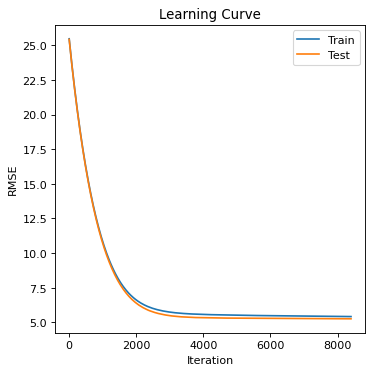

In [23]:
results = xgb_reg.evals_result()
plt.figure(figsize=(5, 5), dpi=80)
# plot learning curves
plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Test')
# show the legend
plt.legend()
# Add title and axis names
plt.title('Learning Curve')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
# show the plot
plt.savefig('./assets/learning-curve.png')
plt.show()

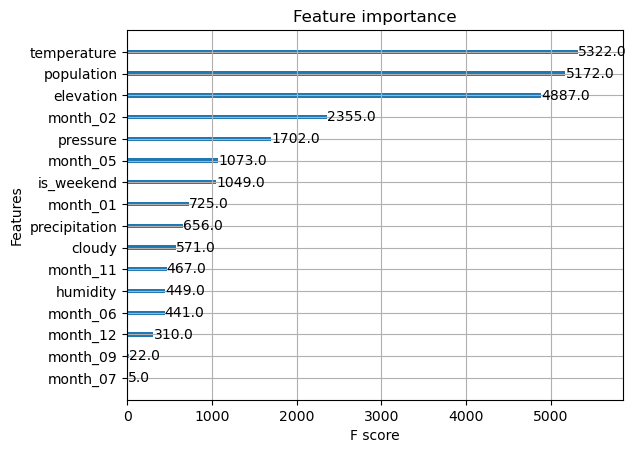

In [26]:
# plot feature importance
xgb_reg.get_booster().feature_names = train.columns[1:].to_list()
xgboost.plot_importance(xgb_reg.get_booster())
plt.savefig('./assets/feature-importance.png')

### Storing the best model

In [14]:
# save the model to disk
filename = './stored-models/xgb_reg.sav'
pickle.dump(xgb_reg, open(filename, 'wb'))